# 1. Download and unzip data

In [2]:
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv
# !unzip "./ISBI2016_ISIC_Part3_Test_Data.zip"
# !unzip "./ISBI2016_ISIC_Part3_Training_Data.zip"

# 2. Make training, validation and test image folders by training and test csv files
[ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)

In [2]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
'''
You are recommended to use torchvision.datasets.ImageFolder to load data into the Pytorch dataset.
To employ ImageFolder, the images should be arranged into:

  root: train/val/test
    class_a
      a1.png
      a2.png
      ...
    class_b
      b1.png
      b2.png
      ...

Write your codes here to organize the original data and split the data into training/validation/test set.
'''

# create directories
os.makedirs('./train', exist_ok=True)
os.makedirs('./train/benign', exist_ok=True)
os.makedirs('./train/malignant', exist_ok=True)
os.makedirs('./val', exist_ok=True)
os.makedirs('./val/benign', exist_ok=True)
os.makedirs('./val/malignant', exist_ok=True)
os.makedirs('./test', exist_ok=True)
os.makedirs('./test/benign', exist_ok=True)
os.makedirs('./test/malignant', exist_ok=True)

# read csv files
df_train = pd.read_csv("./ISBI2016_ISIC_Part3_Training_GroundTruth.csv")
df_test = pd.read_csv("./ISBI2016_ISIC_Part3_Test_GroundTruth.csv")

# split testing into testing and validation dataset
split_test_size = int(0.5*(len(df_test)+1))  # from test data, split 50% as validation set
split_valid_size = (len(df_test)+1) - split_test_size  # split 50% as test set
train_size = 900

print(f"Train data size: {train_size}\nVal data size: {split_valid_size}\nTest data size: {split_test_size}")

# setup training data
shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/ISIC_0000000.jpg", "./train/benign/ISIC_0000000.jpg") # need to copy first one manually as for loop starts one row below
# go through csv, put into corresponding directory
num_train_benign=1
num_train_malignant=0
for i in range(len(df_train)):
  name, label = df_train.iloc[i,0], df_train.iloc[i,1]
  # print(name, label)
  # copy into training directory
  if label == "benign":
    num_train_benign+=1
  elif label == "malignant":
    num_train_malignant+=1
  shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train/"+label+"/"+name+".jpg")

# validation
# need to copy first one manually as for loop starts one row below
shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg", "./val/benign/ISIC_0000003.jpg")
num_val_benign=1
num_val_malignant=0
for i in range(split_valid_size-1):
  name, label = df_test.iloc[i,0], df_test.iloc[i,1]
  # print(name, label)
  if label == 0:
    label = "benign"
    num_val_benign+=1
  else:
    label = "malignant"
    num_val_malignant+=1
  # copy into training directory
  shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/"+name+".jpg", "./val/"+label+"/"+name+".jpg")

# testing
num_test_benign = 0
num_test_malignant = 0
for i in range(split_valid_size-1, len(df_test)):
  name, label = df_test.iloc[i,0], df_test.iloc[i,1]
  # print(name, label)
  if label == 0:
    label = "benign"
    num_test_benign+=1
  else:
    label = "malignant"
    num_test_malignant+=1
  # copy into training directory
  shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/"+name+".jpg", "./test/"+label+"/"+name+".jpg")


print(f'Train classes: Benign: {num_train_benign}, Malignant: {num_train_malignant}')
print(f'Val classes: Benign: {num_val_benign}, Malignant: {num_val_malignant}')
print(f'Test classes: Benign: {num_test_benign}, Malignant: {num_test_malignant}')


Train data size: 900
Val data size: 190
Test data size: 189
Train classes: Benign: 727, Malignant: 173
Val classes: Benign: 148, Malignant: 42
Test classes: Benign: 156, Malignant: 33


# 3. Prepare data and build dataloaders

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch

root_train, root_val, root_test = './train', './val', './test' # -- write your codes here: the root path of training/validation/test set

train_transform = transforms.Compose([
    # -- write your codes here: data preprocessing and augmentation
    transforms.RandomResizedCrop(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    # -- write your codes here: data preprocessing
    transforms.Resize(224),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def get_train_test_set(batch_size):
    train_dataset = ImageFolder(root_train, transform=train_transform)
    loader_train = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
        )

    val_dataset = ImageFolder(root_val, transform=test_transform)
    loader_val = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    test_dataset = ImageFolder(root_test, transform=test_transform)
    loader_test = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    return loader_train, loader_val, loader_test

batch_size = 16
loader_train, loader_val, loader_test = get_train_test_set(batch_size)

In [13]:
ImageFolder(root_train, transform=train_transform)

Dataset ImageFolder
    Number of datapoints: 900
    Root location: ./train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

# 4. Build the network

## Implement ResNet50

In [49]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

class Bottleneck(nn.Module):
    '''
    The single block in ResNet
    '''
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # -- write your codes here
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample

    def forward(self, x):
        # -- write your codes here
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        # if downsample is not None, then apply downsample
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out
        

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        ### stacking layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        '''
        Buiding ResNet layer by stacking blocks
        '''
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        # -- write your codes here
        
        # implement resnet50
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        # in case
        if self.use_fc:
            print("FC Used")
            x = self.fc_add(x)
        if self.use_dropout:
            print("Dropout Used")
            x = self.dropout(x)

        return x

def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)
    if pre_trained:
        pre_trained = resnet50(weights = "IMAGENET1K_V2").state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50

## Create Classification Model

In [50]:
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(ClassificationModel, self).__init__()
        ### apply a vision encoder (ResNet-50 will be applied here)
        self.encoder = encoder
        # -- write your codes here: add a classifier to project the visual features
        self.classifier = nn.Linear(2048, num_classes) # 512*4=2048
    def forward(self, x):
        # -- write your codes here:
        x = self.encoder(x)
        x = self.classifier(x)
        return x

resnet50 = get_resnet50(pre_trained=True)
model = ClassificationModel(resnet50, 2)

### 5. Train and test your model

In [7]:
import gc
# reset GPU memory if needed
def reset_gpu_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [51]:
reset_gpu_mem()

In [52]:
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score

max_epoch = 10
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

lr = 1e-3
train_loss_list = []
valid_loss_list = []
acc_train_list = []
acc_valid_list = []
train_auc_list = []
val_auc_list = []
best_valid_loss = float('inf')

criterion = nn.CrossEntropyLoss() # -- write your codes here
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9) # -- write your codes here

for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    # for recording metrics
    running_loss = 0.0
    running_correct = 0
    valid_loss = 0.0
    valid_correct = 0
    
    ### training the model
    model.train()

    train_preds_list = np.arange(0)
    train_labels_list = np.arange(0)

    for data in tqdm(loader_train):
        # -- write your codes here

        # set all gradients to zero
        optimizer.zero_grad()

        # fetch data
        inputs, labels = data
        if use_cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # model forward
        outputs = model(inputs) # -- write your code here --


        # calculate loss
        loss = criterion(outputs, labels) # -- write your code here --

        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        running_loss += loss.item()
        running_correct += torch.sum(pred == labels)
        # append to list
        pred_np = np.array(pred.cpu()).astype('float64')
        train_preds_list = np.concatenate((train_preds_list, pred_np))
        labels_np = np.array(labels.cpu()).astype('float64')
        train_labels_list = np.concatenate((train_labels_list, labels_np))
        
        

    ### record the training loss and metrics
    # -- write your codes here
    loss = running_loss / len(loader_train.dataset)
    train_loss_list.append(loss)
    acc_train = running_correct / len(loader_train.dataset)
    acc_train_list.append(acc_train.item())
    train_auc = roc_auc_score(train_labels_list, train_preds_list)
    train_auc_list.append(train_auc)


    ### evaluate on validation set
    model.eval()
    val_preds_list = np.arange(0)
    val_labels_list = np.arange(0)
    valid_correct = 0
    for data in loader_val:
        # -- write your codes here
        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        # model forward
        voutputs = model(images)# -- write your code here --
        
        # calculate loss
        vloss = criterion(voutputs, labels)
        vpred = torch.argmax(voutputs, dim=1)
        valid_loss += vloss.item()
        valid_correct += torch.sum(vpred == labels)
        # append to list
        pred_np = np.array(vpred.cpu()).astype('float64')
        val_preds_list = np.concatenate((val_preds_list, pred_np))
        labels_np = np.array(labels.cpu()).astype('float64')
        val_labels_list = np.concatenate((val_labels_list, labels_np))
    
    ### record the validation loss and metrics, save the best checkpoint
    # -- write your codes here
    # Save best checkpoint
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Saving checkpoint")
        torch.save(model.state_dict(), 'best_checkpoint_lesion.pt')

    # record the validation loss and metrics
    acc_valid = valid_correct / len(loader_val.dataset)
    acc_valid_list.append(acc_valid.item())
    valid_loss = valid_loss / len(loader_val.dataset)
    valid_loss_list.append(valid_loss)
    val_auc = roc_auc_score(val_labels_list, val_preds_list)
    val_auc_list.append(val_auc)

    print("Train Loss {:.4f}, Valid Loss {:.4f}, Train Accuracy {:.4f}%, Validation Accuracy {:.4f}%".format(
        loss,
        valid_loss,
        acc_train * 100,
        acc_valid * 100
    ))

    

model.load_state_dict(torch.load('best_checkpoint_lesion.pt'))

### evaluate on test set
model.eval()
test_loss = 0.0
correct = 0
total = len(loader_test.dataset)
test_preds_list = []
test_labels_list = []

for data in loader_test:
    # -- write your codes here
    # fetch data
    images, labels = data
    if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
    
    # model forward
    outputs = model(images)
    
    # calculate accuracy on test set
    pred = torch.argmax(outputs, dim=1)
    tloss = criterion(outputs, labels)
    test_loss += tloss.item()
    correct += torch.sum(pred == labels)
    # append to list
    test_preds_list.append(torch.argmax(outputs, dim=1).detach().cpu().numpy())
    test_labels_list.append(labels.detach().cpu().numpy())



### compute and print the metrics on test set
# -- write your codes here
test_preds = np.concatenate(test_preds_list)
test_labels = np.concatenate(test_labels_list)
test_auc = roc_auc_score(test_labels, test_preds)
test_acc = accuracy_score(test_labels, test_preds)

 -- Epoch 1/10


  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 57/57 [00:23<00:00,  2.40it/s]


Saving checkpoint
Train Loss 0.0312, Valid Loss 0.0328, Train Accuracy 80.3333%, Validation Accuracy 77.8947%
 -- Epoch 2/10


100%|██████████| 57/57 [00:23<00:00,  2.39it/s]


Train Loss 0.0282, Valid Loss 0.0347, Train Accuracy 80.7778%, Validation Accuracy 77.8947%
 -- Epoch 3/10


100%|██████████| 57/57 [00:23<00:00,  2.41it/s]


Saving checkpoint
Train Loss 0.0266, Valid Loss 0.0282, Train Accuracy 81.0000%, Validation Accuracy 78.9474%
 -- Epoch 4/10


100%|██████████| 57/57 [00:23<00:00,  2.41it/s]


Train Loss 0.0255, Valid Loss 0.0287, Train Accuracy 81.7778%, Validation Accuracy 79.4737%
 -- Epoch 5/10


100%|██████████| 57/57 [00:23<00:00,  2.39it/s]


Saving checkpoint
Train Loss 0.0247, Valid Loss 0.0277, Train Accuracy 82.2222%, Validation Accuracy 81.0526%
 -- Epoch 6/10


100%|██████████| 57/57 [00:23<00:00,  2.41it/s]


Saving checkpoint
Train Loss 0.0239, Valid Loss 0.0264, Train Accuracy 83.2222%, Validation Accuracy 79.4737%
 -- Epoch 7/10


100%|██████████| 57/57 [00:24<00:00,  2.37it/s]


Saving checkpoint
Train Loss 0.0231, Valid Loss 0.0263, Train Accuracy 84.3333%, Validation Accuracy 82.6316%
 -- Epoch 8/10


100%|██████████| 57/57 [00:23<00:00,  2.40it/s]


Saving checkpoint
Train Loss 0.0233, Valid Loss 0.0258, Train Accuracy 83.8889%, Validation Accuracy 82.6316%
 -- Epoch 9/10


100%|██████████| 57/57 [00:23<00:00,  2.40it/s]


Saving checkpoint
Train Loss 0.0233, Valid Loss 0.0227, Train Accuracy 84.2222%, Validation Accuracy 86.8421%
 -- Epoch 10/10


100%|██████████| 57/57 [00:23<00:00,  2.40it/s]


Train Loss 0.0219, Valid Loss 0.0263, Train Accuracy 85.3333%, Validation Accuracy 81.0526%


In [53]:
# 2.  Report accuracy and AUC on the test set
print("\nBest model accuracy on test set: {:.2f}%".format(test_acc * 100))
print("Testing AUC: {:.2f}%".format(test_auc * 100))


Best model accuracy on test set: 83.07%
Testing AUC: 68.24%


Plots

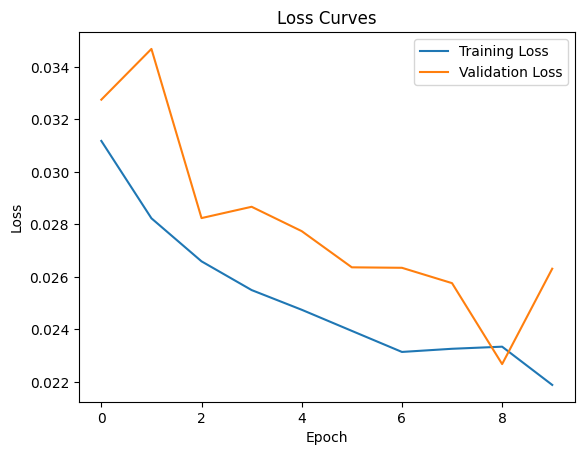

In [54]:
### 3. plot your training and test curves
# training loss curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.plot(valid_loss_list, label='Validation Loss')
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

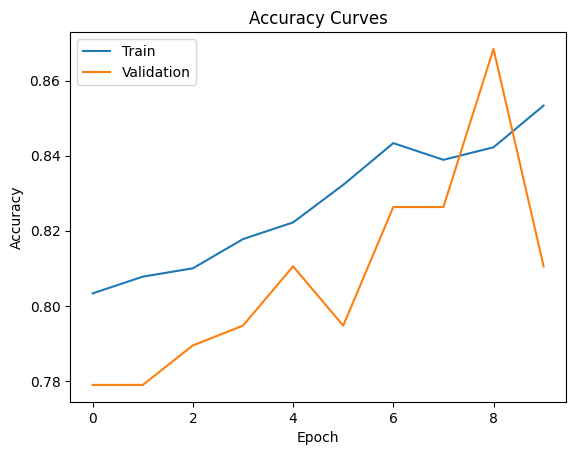

In [55]:
# training and testing accuracy curves
plt.figure()
plt.title("Accuracy Curves")
plt.plot(acc_train_list, label="Train")
plt.plot(acc_valid_list, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

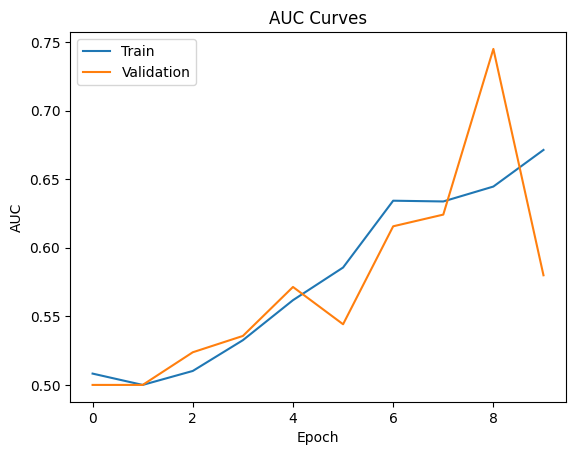

In [56]:
plt.figure()
plt.title("AUC Curves")
plt.plot(train_auc_list, label="Train")
plt.plot(val_auc_list, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.show()

### Dealing with class imbalance

Will deal with imbalance by using weighted loss function for CrossEntropyLoss function

In [38]:
# check imbalance
print(f'Train classes: Benign: {num_train_benign}, Malignant: {num_train_malignant}')
print(f'Val classes: Benign: {num_val_benign}, Malignant: {num_val_malignant}')
print(f'Test classes: Benign: {num_test_benign}, Malignant: {num_test_malignant}')

print(f'Classes ID: {loader_train.dataset.class_to_idx}')

Train classes: Benign: 727, Malignant: 173
Val classes: Benign: 148, Malignant: 42
Test classes: Benign: 156, Malignant: 33
Classes ID: {'benign': 0, 'malignant': 1}


In [39]:
reset_gpu_mem()

In [40]:
# set weights based on imbalance
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

benign_weight = 1/ (num_train_benign/len(loader_train.dataset))
malignant_weight = 1/ (num_train_malignant/len(loader_train.dataset))

class_weights = [benign_weight, malignant_weight]
weights = torch.FloatTensor(class_weights).to(device)

In [41]:
criterion = nn.CrossEntropyLoss(weight=weights) # -- write your codes here

from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score

max_epoch = 10
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

lr = 1e-3
train_loss_list = []
valid_loss_list = []
acc_train_list = []
acc_valid_list = []
train_auc_list = []
val_auc_list = []
best_valid_loss = float('inf')

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9) # -- write your codes here

for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    # for recording metrics
    running_loss = 0.0
    running_correct = 0
    valid_loss = 0.0
    valid_correct = 0
    
    ### training the model
    model.train()

    train_preds_list = np.arange(0)
    train_labels_list = np.arange(0)

    for data in tqdm(loader_train):
        # -- write your codes here

        # set all gradients to zero
        optimizer.zero_grad()

        # fetch data
        inputs, labels = data
        if use_cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # model forward
        outputs = model(inputs) # -- write your code here --


        # calculate loss
        loss = criterion(outputs, labels) # -- write your code here --

        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        running_loss += loss.item()
        running_correct += torch.sum(pred == labels)
        # append to list
        pred_np = np.array(pred.cpu()).astype('float64')
        train_preds_list = np.concatenate((train_preds_list, pred_np))
        labels_np = np.array(labels.cpu()).astype('float64')
        train_labels_list = np.concatenate((train_labels_list, labels_np))
        
        

    ### record the training loss and metrics
    # -- write your codes here
    loss = running_loss / len(loader_train.dataset)
    train_loss_list.append(loss)
    acc_train = running_correct / len(loader_train.dataset)
    acc_train_list.append(acc_train.item())
    train_auc = roc_auc_score(train_labels_list, train_preds_list)
    train_auc_list.append(train_auc)


    ### evaluate on validation set
    model.eval()
    val_preds_list = np.arange(0)
    val_labels_list = np.arange(0)
    valid_correct = 0
    for data in loader_val:
        # -- write your codes here
        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        # model forward
        voutputs = model(images)# -- write your code here --
        
        # calculate loss
        vloss = criterion(voutputs, labels)
        vpred = torch.argmax(voutputs, dim=1)
        valid_loss += vloss.item()
        valid_correct += torch.sum(vpred == labels)
        # append to list
        pred_np = np.array(vpred.cpu()).astype('float64')
        val_preds_list = np.concatenate((val_preds_list, pred_np))
        labels_np = np.array(labels.cpu()).astype('float64')
        val_labels_list = np.concatenate((val_labels_list, labels_np))
    
    ### record the validation loss and metrics, save the best checkpoint
    # -- write your codes here
    # Save best checkpoint
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # print("Saving checkpoint")
        torch.save(model.state_dict(), 'best_checkpoint_lesion.pt')

    # record the validation loss and metrics
    acc_valid = valid_correct / len(loader_val.dataset)
    acc_valid_list.append(acc_valid.item())
    valid_loss = valid_loss / len(loader_val.dataset)
    valid_loss_list.append(valid_loss)
    val_auc = roc_auc_score(val_labels_list, val_preds_list)
    val_auc_list.append(val_auc)

    print("Train Loss {:.4f}, Valid Loss {:.4f}, Train Accuracy {:.4f}%, Validation Accuracy {:.4f}%".format(
        loss,
        valid_loss,
        acc_train * 100,
        acc_valid * 100
    ))

    

model.load_state_dict(torch.load('best_checkpoint_lesion.pt'))

### evaluate on test set
model.eval()
test_loss = 0.0
correct = 0
total = len(loader_test.dataset)
test_preds_list = []
test_labels_list = []

for data in loader_test:
    # -- write your codes here
    # fetch data
    images, labels = data
    if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
    
    # model forward
    outputs = model(images)
    
    # calculate accuracy on test set
    pred = torch.argmax(outputs, dim=1)
    tloss = criterion(outputs, labels)
    test_loss += tloss.item()
    correct += torch.sum(pred == labels)
    # append to list
    test_preds_list.append(torch.argmax(outputs, dim=1).detach().cpu().numpy())
    test_labels_list.append(labels.detach().cpu().numpy())



### compute and print the metrics on test set
# -- write your codes here
test_preds = np.concatenate(test_preds_list)
test_labels = np.concatenate(test_labels_list)
test_auc = roc_auc_score(test_labels, test_preds)
test_acc = accuracy_score(test_labels, test_preds)

 -- Epoch 1/10


100%|██████████| 57/57 [00:23<00:00,  2.42it/s]


Saving checkpoint
Train Loss 0.0324, Valid Loss 0.0287, Train Accuracy 80.1111%, Validation Accuracy 82.6316%
 -- Epoch 2/10


100%|██████████| 57/57 [00:23<00:00,  2.39it/s]


Train Loss 0.0285, Valid Loss 0.0317, Train Accuracy 80.8889%, Validation Accuracy 81.0526%
 -- Epoch 3/10


100%|██████████| 57/57 [00:23<00:00,  2.41it/s]


Train Loss 0.0280, Valid Loss 0.0394, Train Accuracy 81.4445%, Validation Accuracy 77.8947%
 -- Epoch 4/10


100%|██████████| 57/57 [00:23<00:00,  2.39it/s]


Train Loss 0.0271, Valid Loss 0.0312, Train Accuracy 80.4445%, Validation Accuracy 80.0000%
 -- Epoch 5/10


100%|██████████| 57/57 [00:23<00:00,  2.41it/s]


Train Loss 0.0286, Valid Loss 0.0314, Train Accuracy 81.2222%, Validation Accuracy 80.0000%
 -- Epoch 6/10


100%|██████████| 57/57 [00:23<00:00,  2.39it/s]


Train Loss 0.0266, Valid Loss 0.0347, Train Accuracy 80.8889%, Validation Accuracy 81.5789%
 -- Epoch 7/10


100%|██████████| 57/57 [00:23<00:00,  2.40it/s]


Train Loss 0.0234, Valid Loss 0.0413, Train Accuracy 84.3333%, Validation Accuracy 78.4211%
 -- Epoch 8/10


100%|██████████| 57/57 [00:23<00:00,  2.40it/s]


Train Loss 0.0247, Valid Loss 0.0366, Train Accuracy 83.0000%, Validation Accuracy 81.0526%
 -- Epoch 9/10


100%|██████████| 57/57 [00:23<00:00,  2.39it/s]


Train Loss 0.0233, Valid Loss 0.0394, Train Accuracy 82.1111%, Validation Accuracy 81.0526%
 -- Epoch 10/10


100%|██████████| 57/57 [00:23<00:00,  2.38it/s]


Train Loss 0.0228, Valid Loss 0.0334, Train Accuracy 84.6667%, Validation Accuracy 76.8421%


In [42]:
# display results
print("\nBest model accuracy on test set: {:.2f}%".format(test_acc * 100))
print("Testing AUC: {:.2f}%".format(test_auc * 100))


Best model accuracy on test set: 84.13%
Testing AUC: 71.27%


Plot

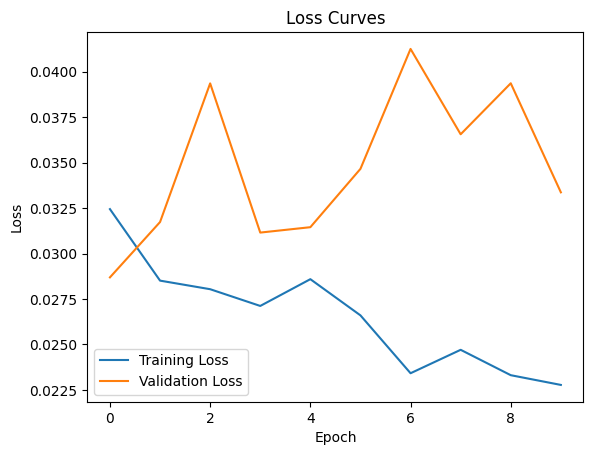

In [45]:
### 3. plot your training and test curves
# training loss curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.plot(valid_loss_list, label='Validation Loss')
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

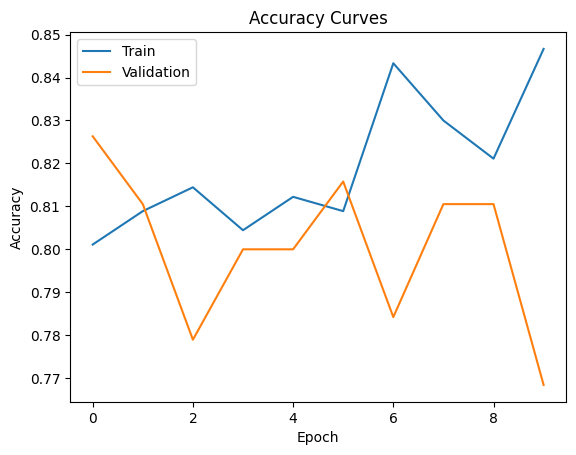

In [46]:
# training and testing accuracy curves
plt.figure()
plt.title("Accuracy Curves")
plt.plot(acc_train_list, label="Train")
plt.plot(acc_valid_list, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()